<a href="https://colab.research.google.com/github/hansbrunner/epidemiology-analysis/blob/main/Framingham_Heart_Study/Framingham_Heart_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
"""
The dataset (Framingham Heart Study) used for this analysis contains medical and lifestyle information related
to the prediction of Coronary Heart Disease (CHD). The goal of the analysis was to identify the most important risk factors
contributing to the development of CHD and to build a predictive model that accurately identifies individuals at risk.
The dataset includes continuous variables such as age, BMI, and blood pressure, as well as binary variables like gender and smoking status.
"""

'\nThe dataset (Framingham Heart Study) used for this analysis contains medical and lifestyle information related\nto the prediction of Coronary Heart Disease (CHD). The goal of the analysis was to identify the most important risk factors \ncontributing to the development of CHD and to build a predictive model that accurately identifies individuals at risk. \nThe dataset includes continuous variables such as age, BMI, and blood pressure, as well as binary variables like gender and smoking status.\n'

In [107]:
import pandas as pd

# get data
df = pd.read_csv("framingham.csv") # insert path to file

# Impute or remove missing data
df = df.dropna()  # The simple way

# Create dummy variable for education
df = pd.get_dummies(df, columns=['education'], drop_first=True).astype(int)





In [125]:
# Start with feature selection
# Continuous variables
continuous_columns = ['age', 'totChol', 'BMI', 'sysBP', 'diaBP', 'cigsPerDay', 'heartRate', 'glucose']

# Binary variables
binary_columns = ['male', 'education_2.0', 'education_3.0', 'education_4.0'
                  ,'currentSmoker', 'BPMeds','prevalentStroke', 'prevalentHyp','diabetes']


In [119]:
# Feature selection of continuous varibles with ANOVA F-test
from sklearn.feature_selection import SelectKBest, f_classif

# Select features using ANOVA F-test
X_cont = df[continuous_columns]
y = df['TenYearCHD']

# Apply SelectKBest to extract the top features based on F-test
f_selector = SelectKBest(f_classif, k='all')
f_selector.fit(X_cont, y)

# Get F-scores and p-values
f_scores = f_selector.scores_
p_values = f_selector.pvalues_

# Create a DataFrame to show the results
f_test_results = pd.DataFrame({
    'Feature': continuous_columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort the features by F-Score
f_test_results = f_test_results.sort_values(by='F-Score', ascending=False)
print(f_test_results)

      Feature     F-Score       P-Value
0         age  211.751448  1.122701e-46
3       sysBP  190.757964  2.468141e-42
4       diaBP   84.859849  5.261277e-20
7     glucose   55.228777  1.328790e-13
1     totChol   30.757290  3.131233e-08
2         BMI   26.230512  3.186426e-07
5  cigsPerDay    9.917900  1.649990e-03
6   heartRate    1.539186  2.148186e-01


In [120]:
# Feature selection of binary variables with Chi2
from sklearn.feature_selection import chi2

# Select binary variables
X_bin = df[binary_columns]

# Apply SelectKBest using chi2 for categorical variables
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_bin, y)

# Get chi2 scores and p-values
chi2_scores = chi2_selector.scores_
chi2_p_values = chi2_selector.pvalues_

# Create a DataFrame to show the results
chi2_results = pd.DataFrame({
    'Feature': binary_columns,
    'Chi2-Score': chi2_scores,
    'P-Value': chi2_p_values
})

# Sort the features by Chi2-Score
chi2_results = chi2_results.sort_values(by='Chi2-Score', ascending=False)
print(chi2_results)


           Feature  Chi2-Score       P-Value
7     prevalentHyp   82.845455  8.872601e-20
8         diabetes   31.067621  2.491938e-08
5           BPMeds   28.191569  1.098822e-07
0             male   17.107751  3.531788e-05
1    education_2.0    9.450345  2.111094e-03
6  prevalentStroke    8.507833  3.536210e-03
2    education_3.0    3.937698  4.721533e-02
4    currentSmoker    0.686474  4.073664e-01
3    education_4.0    0.356144  5.506558e-01


In [126]:
# Based on this initial feature selection, I decide to drop: currentSmoker and heartRate (not significant)
continuous_columns.remove("heartRate")
binary_columns.remove("currentSmoker")

In [122]:
# Next, remove based on collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select the remaining features
X = df[continuous_columns]

# Add a constant (intercept)
X = add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)
# No variables removed - multicollinearity within continous features are not an issue

     Variable         VIF
0       const  102.568507
1         age    1.307070
2     totChol    1.100894
3         BMI    1.188993
4       sysBP    3.088332
5       diaBP    2.855993
6  cigsPerDay    1.042854
7     glucose    1.031215


15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


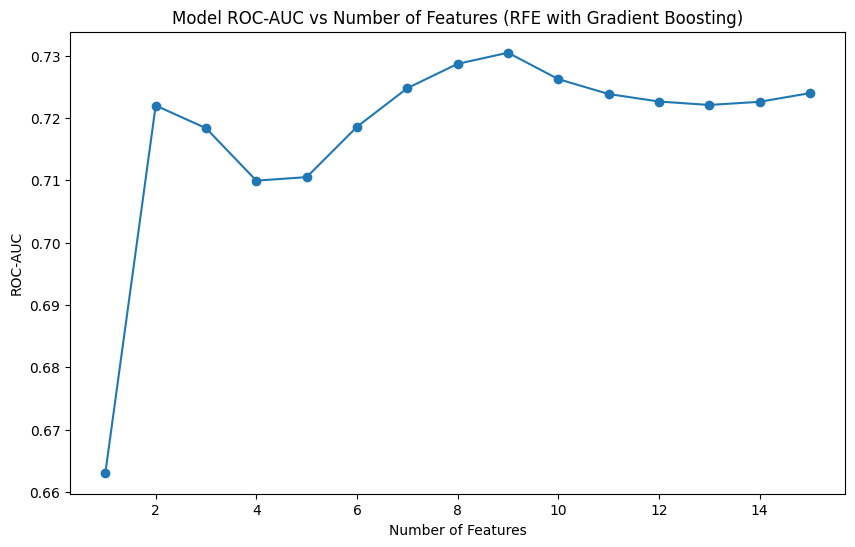

In [127]:
# Recursive Feature Elimination using Gradient Boosting. Hyperparameter tuning will come later
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalized continuous variables
model_df = df.copy()
model_df[continuous_columns] = StandardScaler().fit_transform(model_df[continuous_columns])

X = model_df[binary_columns+continuous_columns]
y = df["TenYearCHD"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

# Initialize Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# Initialize RFE with the model
rfe = RFE(estimator=model, n_features_to_select=1, step=1)  # Start with all features, remove one at a time

# Track ROC-AUC
n_features = X_train.shape[1]
roc_auc_scores = []

# Fit RFE
for i in range(n_features, 0, -1):
    print(i)
    rfe.n_features_to_select = i
    rfe.fit(X_train, y_train)
    y_pred_proba = rfe.predict_proba(X_test)[:, 1]  # Predict probabilities for ROC-AUC

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores.append(roc_auc)

# Plot the number of features vs ROC-AUC
plt.figure(figsize=(10, 6))
plt.plot(range(n_features, 0, -1), roc_auc_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.title('Model ROC-AUC vs Number of Features (RFE with Gradient Boosting)')
plt.show()

In [129]:
# Show rankings from RFE
ranking = rfe.ranking_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Rank': ranking})
# Sort the DataFrame by ranking
features_df = features_df.sort_values(by='Rank')

# Display the ordered features
print(features_df)

# Based on this, and the plot, I discard 4 features: education, prevalentHyp,BPMeds,diabetes
# This is interesting based on previous results, that especially BPMeds, prevalentHyp and diabetes where highly correlated with CHD.
# This suggest that these features carry redundant information, i.e. the predictive power is low.
# These variables might be redundant to age, glucose, and blood pressure.

cols_to_remove = ['education_2.0','prevalentHyp','BPMeds','diabetes','education_3.0','education_4.0','prevalentStroke']
binary_columns = [item for item in binary_columns if item not in cols_to_remove]

final_df = df[continuous_columns+binary_columns]

            Feature  Rank
11            sysBP     1
8               age     2
14          glucose     3
9           totChol     4
12            diaBP     5
13       cigsPerDay     6
0              male     7
10              BMI     8
3     education_4.0     9
1     education_2.0    10
5   prevalentStroke    11
7          diabetes    12
6      prevalentHyp    13
2     education_3.0    14
4            BPMeds    15


In [130]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold

def evaluate_model_cv(model, X, y, cv=5):
    """
    This function evaluates a given model using cross-validation.

    Parameters:
    - model: The machine learning model to evaluate (e.g., LogisticRegression, RandomForestClassifier).
    - X: Feature set.
    - y: Target labels.
    - cv: Number of cross-validation folds

    Returns:
    - A dictionary containing relevant evaluation metrics such as:
      * AUC-ROC score
      * Classification report
      * Confusion matrix
      * False Positive Rate (fpr) and True Positive Rate (tpr)
    """


    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=skf, method='predict')

    # Get predicted probabilities for AUC-ROC (using predict_proba if available, otherwise decision_function)
    if hasattr(model, "predict_proba"):
        y_proba = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:, 1]
    else:
        y_proba = cross_val_predict(model, X, y, cv=skf, method='decision_function')

    # Calculate AUC-ROC score across the cv folds
    auc_roc = roc_auc_score(y, y_proba)

    # Classification report
    class_report = classification_report(y, y_pred, output_dict=True)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)

    # ROC Curve data for FPR and TPR
    fpr, tpr, _ = roc_curve(y, y_proba)

    # Return evaluation metrics as a dictionary
    results = {
        "auc_roc": auc_roc,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix,
        "roc_curve": (fpr, tpr)
    }

    return results


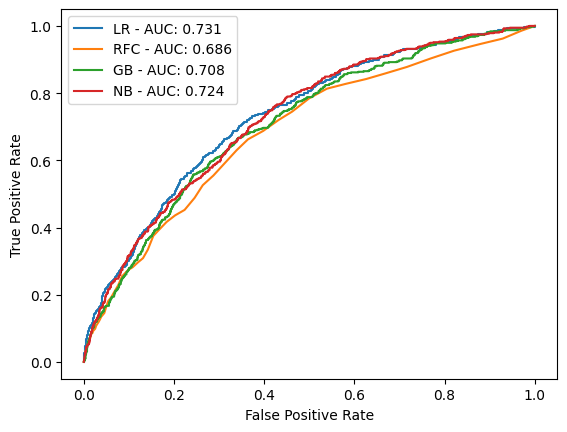

In [131]:
# Evaluate performance of several models: logistic regression, random forest classifier,
# gradient boost, and naive bayes
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# scale features
scaler = StandardScaler() # Z-score
X = scaler.fit_transform(final_df)

# Initialize models
models = [LogisticRegression(class_weight='balanced'),RandomForestClassifier(class_weight='balanced', random_state=10),
          GradientBoostingClassifier(random_state=10), GaussianNB()]
model_names = ['LR','RFC','GB','NB']

metrics_list = []
# Figure
plt.figure()

# Loop through models and plot ROC (fpr v tpr)
for i, model in enumerate(models):
  results = evaluate_model_cv(model, X, y, cv=5)
  plt.plot(results['roc_curve'][0],results['roc_curve'][1],label=f"{model_names[i]} - AUC: {results['auc_roc']:.3f}")
  # get precision, recall and F1
  precision = results['classification_report']['1']['precision']
  recall = results['classification_report']['1']['recall']
  f1_score = results['classification_report']['1']['f1-score']
  # append to metrics_df
  metrics_list.append({
        'Model': model_names[i],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

metrics_df = pd.DataFrame(metrics_list)

<Figure size 640x480 with 0 Axes>

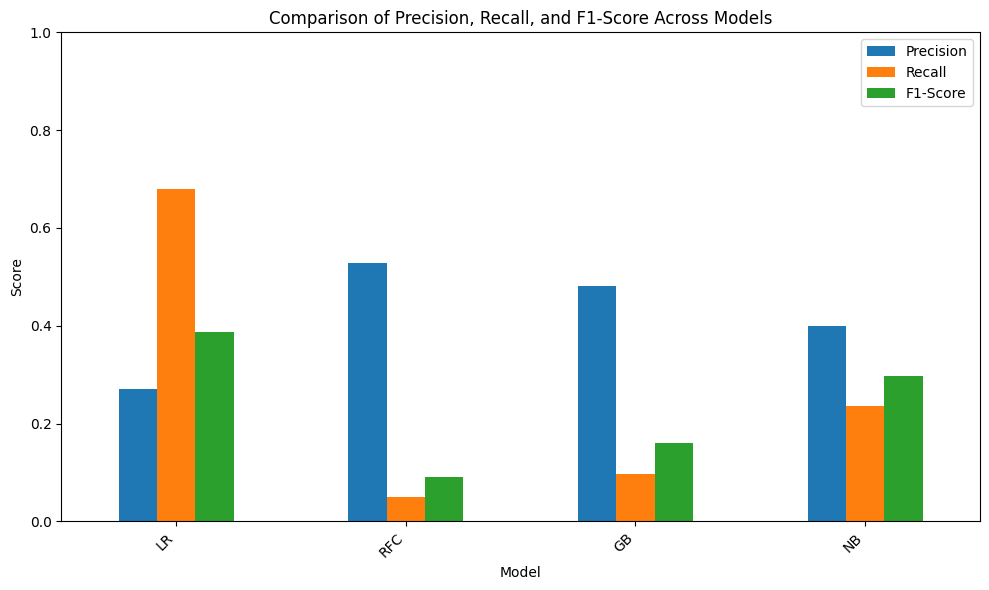

In [132]:
# Set up the figure
plt.figure()

# Bar plot for precision, recall, and F1-Score
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))

# Set plot labels and title
plt.title('Comparison of Precision, Recall, and F1-Score Across Models')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Scores between 0 and 1

# Display the plot
plt.tight_layout()
plt.show()

# Overall precision is quite good, meaning that the people the models predicts as having CHD, often has CHD.
# However, this comes with a cost of low recall (primarily for RFC, GB and NB), meaning that the models misses most of the actual CHD.
# This might be due to the unbalanced dataset, and the models have a hard time predicting the minority class (CHD)

In [133]:
# Synthetic Minority Oversampling Technique (SMOTE) to improve recall
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# scale features
scaler = StandardScaler() # Z-score
X = scaler.fit_transform(final_df)

metrics_list=[]
for i, model in enumerate(models):
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=1)),
        ('model', model)
    ])

    # Perform cross-validation predictions with the pipeline
    y_pred = cross_val_predict(pipeline, X, y, cv=5)
    class_report = classification_report(y,y_pred,output_dict=True)
    print(class_report)
    metrics_list.append({
        'Model': model_names[i],
        'Precision': class_report['1']['precision'],
        'Recall': class_report['1']['recall'],
        'F1-Score': class_report['1']['f1-score']
    })

metrics_df = pd.DataFrame(metrics_list)

{'0': {'precision': 0.9181053563523683, 'recall': 0.6688165108029668, 'f1-score': 0.7738805970149254, 'support': 3101.0}, '1': {'precision': 0.26590421729807007, 'recall': 0.6678635547576302, 'f1-score': 0.3803680981595092, 'support': 557.0}, 'accuracy': 0.6686714051394205, 'macro avg': {'precision': 0.5920047868252192, 'recall': 0.6683400327802984, 'f1-score': 0.5771243475872173, 'support': 3658.0}, 'weighted avg': {'precision': 0.8187953414662982, 'recall': 0.6686714051394205, 'f1-score': 0.7139608425418619, 'support': 3658.0}}
{'0': {'precision': 0.8708971553610503, 'recall': 0.8984198645598194, 'f1-score': 0.8844444444444445, 'support': 3101.0}, '1': {'precision': 0.3137254901960784, 'recall': 0.2585278276481149, 'f1-score': 0.28346456692913385, 'support': 557.0}, 'accuracy': 0.80098414434117, 'macro avg': {'precision': 0.5923113227785644, 'recall': 0.5784738461039671, 'f1-score': 0.5839545056867892, 'support': 3658.0}, 'weighted avg': {'precision': 0.786057183382677, 'recall': 0.8

<Figure size 640x480 with 0 Axes>

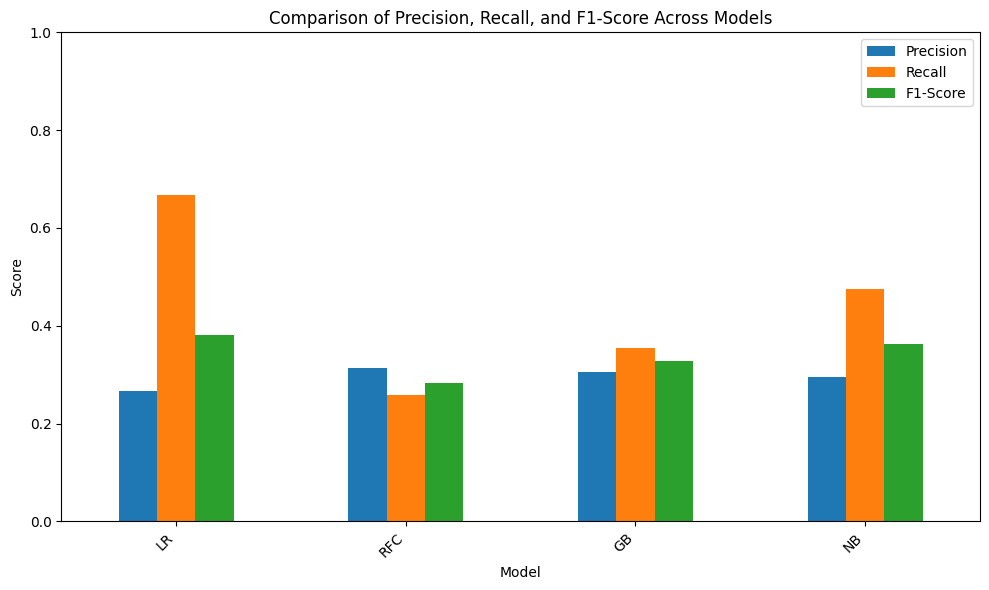

In [134]:
# Set up the figure
plt.figure()

# Bar plot for precision, recall, and F1-Score
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))

# Set plot labels and title
plt.title('Comparison of Precision, Recall, and F1-Score Across Models')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Scores between 0 and 1

# Display the plot
plt.tight_layout()
plt.show()
# A small improvement compared to before, however the models are still not very good at predicting CHD cases from the data

In [135]:
# Hyperparameter tuning of gradient boost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_dist = {
    'model__n_estimators': [100, 200, 300],  # Number of trees
    'model__learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'model__max_depth': [3, 5, 7],  # Depth of the tree
    'model__subsample': [0.7, 0.8, 1.0],  # Fraction of samples used per tree
    'model__min_samples_split': [10, 20, 30],  # Minimum samples required to split a node
    'model__min_samples_leaf': [5, 10, 20],  # Minimum samples required in a leaf node
    'model__max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
}

# Pipeline with SMOTE and Gradient Boosting
pipeline = Pipeline([
    ('smote', SMOTE(random_state=1)),
    ('model', GradientBoostingClassifier(random_state=1))
])

# RandomizedSearchCV - optimize F1
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=30,
                                   scoring='f1', cv=5, random_state=1, n_jobs=-1, verbose=1)

# Fit the RandomizedSearchCV on your data
random_search.fit(X, y)

# Get the best parameters and the best model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate the best model
y_pred = cross_val_predict(best_model, X, y, cv=5)
print(classification_report(y, y_pred))

# With hyperparameter tuning, the model gets slightly better, with fairly low precision (many false positives), but a decent recall (captures
#59% of CHD cases). In a clinical setting, recall is a little more important than precision.

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_samples_split': 20, 'model__min_samples_leaf': 10, 'model__max_features': None, 'model__max_depth': 3, 'model__learning_rate': 0.01}
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3101
           1       0.27      0.59      0.37       557

    accuracy                           0.69      3658
   macro avg       0.59      0.65      0.58      3658
weighted avg       0.81      0.69      0.73      3658



In [136]:
# Play with threshold to see if that affects model performance
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

y_proba_cv = cross_val_predict(best_model, X, y, cv=5, method='predict_proba')[:, 1]  # Cross-validated probabilities for the positive class

# thresholds to test from 0.1 to 0.9
thresholds = np.arange(0.1, 1.0, 0.1)


metrics_list = []

for threshold in thresholds:
    # Classify predictions based on the threshold
    y_pred_threshold = (y_proba_cv >= threshold).astype(int)

    # Calculate performance metrics
    precision = precision_score(y, y_pred_threshold)
    recall = recall_score(y, y_pred_threshold)
    f1 = f1_score(y, y_pred_threshold)

    # Save the results
    metrics_list.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })


metrics_df = pd.DataFrame(metrics_list)

#print(metrics_df)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


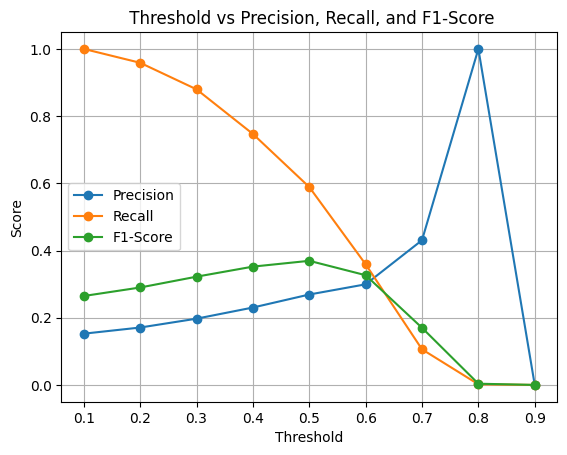

In [137]:
# plot precision, recall and F1 for different thresholds
plt.figure()
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', marker='o')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall', marker='o')
plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], label='F1-Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(' Threshold vs Precision, Recall, and F1-Score')
plt.legend()
plt.grid(True)
plt.show()
# best threshold is 0.5

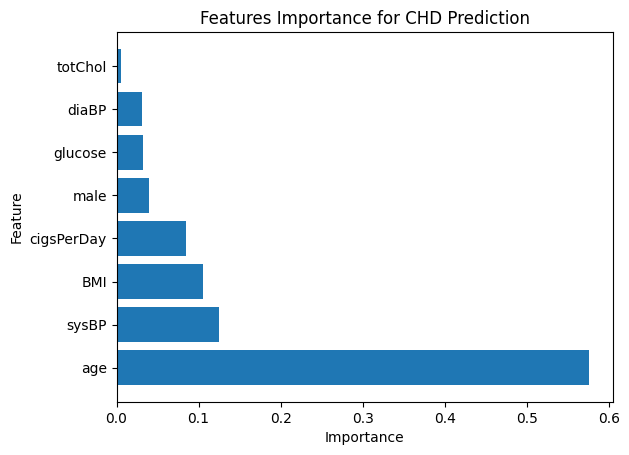

In [138]:
# I stick to this model, even though it is not super good at prediction CHD
# Now look at risk factors for CHD
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = best_model.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': final_df.columns,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the importance of features
plt.figure()
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features Importance for CHD Prediction')
plt.show()
# The majority (almost 60%) of the predictive power of the model is from age.

In [ ]:
"""
Through a series of steps involving feature selection (ANOVA, Chi-squared tests, recursive feature elimination),
and model comparison between logistic regression, random forest, gradient boosting, and naive Bayes,
gradient boosting was selected for future analysis, based on oppurtunity for hyperparameter tuning and recall, precision, and F1-score (Logistic regression was actually best).
After hyperparameter tuning, the model showed moderate predictive performance, with age being the most significant factor (importance of 0.6).
Other important predictors included systolic blood pressure, BMI, cigarettes per day, and being male,
all contributing equally with importance values of approximately 0.1.
These results highlight the key role of age and lifestyle factors in the risk of developing CHD.
Even though the model effectively identifies individuals at risk of CHD (recall ~0.6),
it struggles with false positives (precision ~0.25), suggesting that further refinement is needed for practical use.
Future improvements could incorporate additional data such as genetic information, biomarkers, or other lifestyle factors,
which may provide more predictive power.
"""